# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [2]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [3]:
mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh",
                "culled_mesh.nc", "mesh.nc", periodicity="NonPeriodic_x", nvlevels=5)

MPAS_Ocean{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], 9.8, 50.50762722760972, 10000, Int32[9901 101 … 10000 9900; 2 1 … 100 0; … ; 0 3 … 9899 100; 0 102 … 9900 9999], Int32[9769 10203 … 659 43; 17351 17351 … 12447 7943; … ; 16302 20237 … 1021 17589; 16823 15474 … 2069 659], Int32[4 3 … 20197 19997; 3 4 … 200 20200; … ; 2 5 … 199

In [4]:
meanCoriolisParameterf = sum(mpasOcean.fCell) / mpasOcean.nCells

0.0001

In [5]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [6]:
c = sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [7]:
rossbyRadiusR = c/meanCoriolisParameterf

989949.4936611665

## the lateral profile of the kelvin wave, can be any function

function lateralProfileGaussian(y)
    mu = mpasOcean.lY/2#20.0e5
    sigma = 3.0e3
    return 1e-3*exp(- (y .% mpasOcean.lY -mu)^2 / sigma^2) #* cos(y*5.0e-6)
end

In [8]:
lateralProfile(y, lY) =  1e-3 *cos(y/lY * 4 * pi)

lateralProfile (generic function with 1 method)

In [9]:
lYEdge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)

4.330127018922193e6

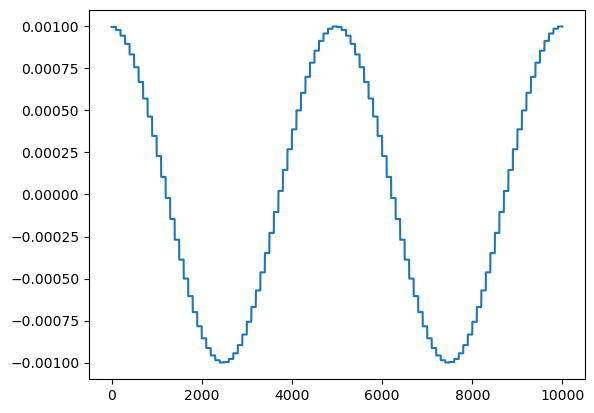

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f48cea43e80>

In [10]:
plot(lateralProfile.(mpasOcean.yCell, lYEdge))

# Initial Condition

In [11]:
kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0) = sin(mpasOcean.angleEdge[iEdge]) * sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfile(mpasOcean.yEdge[iEdge] .+ c*t, lYEdge) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)

kelvinWaveExactNormalVelocity (generic function with 2 methods)

In [12]:
kelvinWaveExactSSH(mpasOcean, iCell, t=0) = - meanFluidThicknessH * lateralProfile(mpasOcean.yCell[iCell] .+ c*t, lYEdge) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)

kelvinWaveExactSSH (generic function with 2 methods)

In [31]:
function kelvinWaveExactSolution!(mpasOcean, t=0)
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        mpasOcean.normalVelocityCurrent[iEdge,:] .= kelvinWaveExactNormalVelocity(mpasOcean, iEdge)
    end
end

kelvinWaveExactSolution! (generic function with 2 methods)

In [32]:
function boundaryCondition!(mpasOcean, t)
    for iEdge in 1:mpasOcean.nEdges
        if mpasOcean.boundaryEdge[iEdge] == 1.0
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end
    
end

boundaryCondition! (generic function with 1 method)

In [33]:
kelvinWaveExactSolution!(mpasOcean)

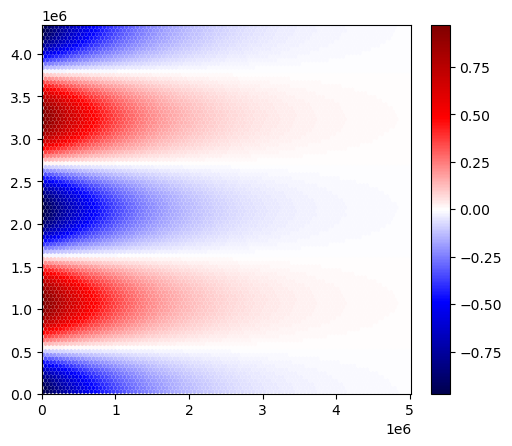

In [34]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Simulate wave

In [36]:
nFrames = 10

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))

saveInterval = 5

t = 0

for i in 1:nFrames
    for j in 1:saveInterval
        
        calculate_normal_velocity_tendency!(mpasOcean)
    
        update_normal_velocity_by_tendency!(mpasOcean)
        
        
        boundaryCondition!(mpasOcean, t)
        
        
        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
    sshOverTime[i,:] = mpasOcean.sshCurrent[:]
    sshOverTimeExact[i,:] = collect([kelvinWaveExactSSH(mpasOcean, iCell, t) for iCell in 1:mpasOcean.nCells])
end

## animate simulation

In [37]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f48cb6b9ac0>

In [38]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [39]:
mpasOcean.normalVelocityCurrent

30200×5 Matrix{Float64}:
  0.0           6.54905e-7    6.54905e-7    6.54905e-7    6.54905e-7
  0.0           5.38721e-7    5.38721e-7    5.38721e-7    5.38721e-7
  0.0           5.9591e-7     5.9591e-7     5.9591e-7     5.9591e-7
  0.0           6.59223e-7    6.59223e-7    6.59223e-7    6.59223e-7
  0.0           7.2926e-7     7.2926e-7     7.2926e-7     7.2926e-7
  0.0           7.67019e-7    7.67019e-7    7.67019e-7    7.67019e-7
  0.0           8.48502e-7    8.48502e-7    8.48502e-7    8.48502e-7
  0.0           8.92432e-7    8.92432e-7    8.92432e-7    8.92432e-7
  0.0           9.38635e-7    9.38635e-7    9.38635e-7    9.38635e-7
  0.0           1.33637e-6    1.33637e-6    1.33637e-6    1.33637e-6
  0.0           1.55477e-6    1.55477e-6    1.55477e-6    1.55477e-6
  0.0           1.63523e-6    1.63523e-6    1.63523e-6    1.63523e-6
  0.0           1.71984e-6    1.71984e-6    1.71984e-6    1.71984e-6
  ⋮                                                      
 -0.00014958   -0.0001

# show exact solution

In [20]:
cMax = maximum(abs.(sshOverTimeExact))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f48cca89760>

In [21]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# difference between exact and numerical solution

In [22]:
cMax = maximum(abs.(sshOverTimeExact))

fig, ax, cbar, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    ax.clear()
#     col.set_array(sshOverTimeExact[i+1,:] - sshOverTime[i+1,:])
    heatMapMesh(mpasOcean, sshOverTimeExact[i+1,:] - sshOverTime[i+1,:], cMin=-cMax, cMax=cMax, fig=fig, ax=ax, cbar=cbar)
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f48cc3af6a0>

In [23]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# error at time horizon

In [24]:
sum( (sshOverTimeExact[end,:] .- sshOverTime[end,:]) .^2 ) / sum(sshOverTimeExact[end,:] .^2)

0.00042293225850691156

In [49]:
function do24step(t)
    for j in 1:24
        
        calculate_normal_velocity_tendency!(mpasOcean)
    
        update_normal_velocity_by_tendency!(mpasOcean)
        
        
        boundaryCondition!(mpasOcean, t)
        
        
        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
end

do24step (generic function with 2 methods)

In [50]:
import BenchmarkTools

In [51]:
t = 0
kelvinWaveExactSolution!(mpasOcean, t)

In [52]:
BenchmarkTools.@benchmark do24step(t)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 10.075 s (4.79% GC) to evaluate,
 with a memory estimate of 7.60 GiB, over 440697008 allocations.

In [29]:
mpasOcean.nVertLevels

5

# debugging tendency

exactSSHTendency = ( mpasOcean.sshCurrent .- collect([kelvinWaveExactSSH(mpasOcean, iCell, mpasOcean.dt) for iCell in 1:mpasOcean.nCells]) ) / mpasOcean.dt
exactNormalVelocityTendency = ( mpasOcean.normalVelocityCurrent .- collect([kelvinWaveExactNormalVelocity(mpasOcean, iEdge, mpasOcean.dt) for iEdge in 1:mpasOcean.nEdges]) ) / mpasOcean.dt

include("mode_forward/calculate_tendencies.jl")

calculate_ssh_tendency!(mpasOcean)
calculate_normal_velocity_tendency!(mpasOcean)

sum(mpasOcean.normalVelocityCurrent)/ length(mpasOcean.normalVelocityCurrent)

mpasOcean.layerThicknessEdge

mpasOcean.dcEdge

mpasOcean.areaCell

5* -0.0002 * 200 * 6 * 50000 / 2.2e9

fig1, _ = heatMapMesh(mpasOcean, exactSSHTendency)
fig1.suptitle("exact ssh tendency")

fig2, _ = heatMapMesh(mpasOcean, mpasOcean.sshTendency)
fig2.suptitle("numerical ssh tendency")

fig3, _ = heatMapMesh(mpasOcean, exactSSHTendency .+ mpasOcean.sshTendency)
fig3.suptitle("error of ssh tendency")

display(fig1), display(fig2), display(fig3)

fig1, _ = edgeHeatMapMesh(mpasOcean, exactNormalVelocityTendency)
fig1.suptitle("exact NV tendency")

fig2, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityTendency)
fig2.suptitle("numerical NV tendency")

fig3, _ = edgeHeatMapMesh(mpasOcean, exactNormalVelocityTendency .- mpasOcean.normalVelocityTendency)
fig3.suptitle("error of NV tendency")

display(fig1), display(fig2), display(fig3)

fig1, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityTendency .* cos.(mpasOcean.angleEdge))
fig1.suptitle("numerical U tendency")

fig2, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityTendency .* sin.(mpasOcean.angleEdge))
fig2.suptitle("numerical V tendency")


display(fig1), display(fig2)

fig1, _ = edgeHeatMapMesh(mpasOcean, exactNormalVelocityTendency .* cos.(mpasOcean.angleEdge))
fig1.suptitle("exact U tendency")

fig2, _ = edgeHeatMapMesh(mpasOcean, exactNormalVelocityTendency .* sin.(mpasOcean.angleEdge))
fig2.suptitle("exact V tendency")


display(fig1), display(fig2)